In [1]:
# load all data
import os
import polars as pl
data_dir = "./generated_all"
df = pl.DataFrame()
for name in os.listdir(data_dir):
    load_df = pl.read_parquet(os.path.join(data_dir, name))
    df = df.vstack(load_df)

# fix name
df = df.with_columns(
    win_total = pl.col("num"),
    win_split = pl.col("win_c"),
    num = pl.col("win"),
).drop(
    pl.col("win"),
    pl.col("win_c"),
    pl.col("name_orig")
)

print(df)


shape: (191_700, 81)
┌──────────┬──────────┬──────────┬──────────┬───┬─────┬────────────────────┬───────────┬───────────┐
│ f1_min   ┆ f1_max   ┆ f1_std   ┆ f1_mean  ┆ … ┆ num ┆ name               ┆ win_total ┆ win_split │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ --- ┆ ---                ┆ ---       ┆ ---       │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ str ┆ str                ┆ str       ┆ str       │
╞══════════╪══════════╪══════════╪══════════╪═══╪═════╪════════════════════╪═══════════╪═══════════╡
│ 0.421616 ┆ 0.857576 ┆ 0.098411 ┆ 0.708625 ┆ … ┆ 9   ┆ dance_data_68_corr ┆ 1         ┆ 0         │
│          ┆          ┆          ┆          ┆   ┆     ┆ ected              ┆           ┆           │
│ 0.851393 ┆ 0.880562 ┆ 0.004946 ┆ 0.877413 ┆ … ┆ 9   ┆ dance_data_134_cor ┆ 3         ┆ 3         │
│          ┆          ┆          ┆          ┆   ┆     ┆ rected             ┆           ┆           │
│ 0.414415 ┆ 0.755034 ┆ 0.093954 ┆ 0.586492 ┆ … ┆ 4   ┆ dance_data_153

## Standard Deviation Of Outputs
This is to study the variance of output.

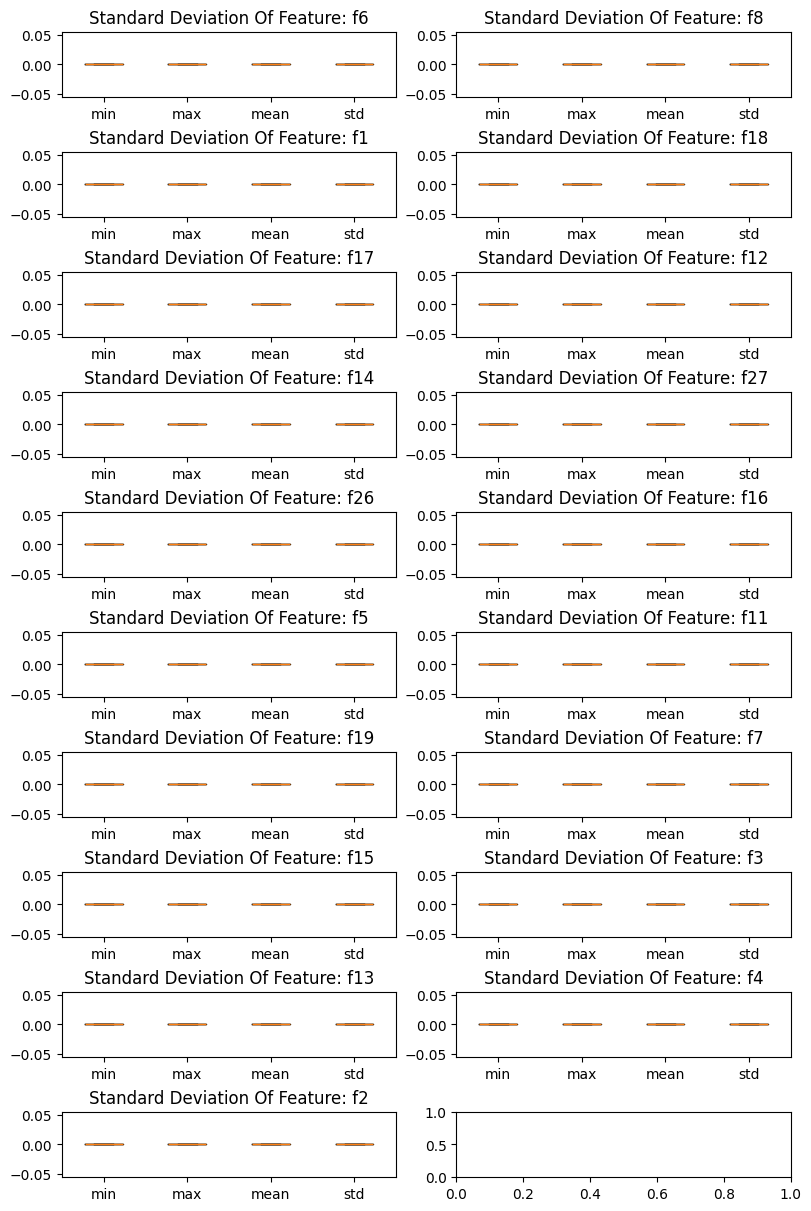

In [2]:
index_df = df.group_by((
        pl.col("name"),
        pl.col("music"),
        pl.col("win_total"),
        pl.col("win_split"),
)).agg(
    pl.all().std().name.suffix("_agg_std"),
)

import matplotlib.pyplot as plt
import math

feats = df.drop("name", "music", "win_total", "win_split", "num").columns
feats_raw = set()
for feat in feats:
    feat_name = feat.split("_")[0]
    feats_raw.add(feat_name)
fig, axs = plt.subplots(math.ceil(len(feats_raw) / 2), 2, layout="constrained", figsize=(8, 12))

aggs = ["min", "max", "mean", "std"]
for i, feat in enumerate(feats_raw):
    this_df = df.select(
        (pl.selectors.starts_with(f"{feat}_")),
    )

    ls = []
    labels=[]
    for agg in aggs:
        ls.append(index_df[f'{feat}_{agg}_agg_std'])
        labels.append(agg)

    x, y = i // 2, i % 2
    axs[x, y].boxplot(ls)
    axs[x, y].set_xticklabels(labels)
    axs[x, y].set_title(f"Standard Deviation Of Feature: {feat}")
plt.show()

> **_NOTE:_** : Run this script to load all the R values for the various Pearson's R analysis.

In [3]:
# Analysis 3 - get r value of input to output
from scipy.stats import pearsonr
from tqdm import tqdm

input_df = pl.read_csv("features_complete.csv") 
output_df = df.clone()
output_df = output_df.drop(
    pl.selectors.ends_with("_min"),
    pl.selectors.starts_with("f12_"),
    pl.selectors.starts_with("f16_"),
)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
name_df = df.clone()

# scale output
scaling_df = output_df.drop(
    pl.col("name"),
    pl.col("num"),
    pl.col("win_total"),
    pl.col("win_split"),
    pl.col("music"),
)
concat_df = output_df.select(
    pl.col("name"),
    pl.col("num"),
    pl.col("win_total"),
    pl.col("win_split"),
    pl.col("music"),
)
scaling_df = pl.DataFrame(scaler.fit_transform(scaling_df))
output_df = scaling_df.hstack(concat_df)
print(output_df)

# scaling input
scaling_df = input_df.drop(
    pl.col("name")
)
concat_df = input_df.select(
    pl.col("name")
)
scaling_df = pl.DataFrame(scaler.fit_transform(scaling_df))
input_df = scaling_df.hstack(concat_df)
print(input_df)

names = input_df.filter(
    pl.col("name") != "dance_data_23_corrected"
)["name"].unique().to_list()
musics = output_df["music"].unique().to_list()


r_df = pl.DataFrame()
for name in tqdm(names):
    for music in musics:
        inputs = input_df.filter(pl.col("name") == name).drop("name").to_numpy()
        outputs = output_df.filter(
            pl.col("name") == name,
            pl.col("num") == "0",
            pl.col("win_total") == "3",
            pl.col("music") == music,
        ).drop("name", "num", "win_total", "music")

        for win in range(0, 4):
            output = outputs.filter(pl.col("win_split") == str(win)).drop("win_split").to_numpy()
            r = pearsonr(inputs[0, :], output[0, :], alternative="two-sided") 
            r_dict = {"name": name, "music": music, "win": win, "r": r.statistic}
            r_df = r_df.vstack(pl.from_dict(r_dict))
    
r_df.write_parquet("r_val_df.parquet")

shape: (191_700, 56)
┌───────────┬───────────┬───────────┬───────────┬───┬─────┬───────────┬───────────┬───────┐
│ column_0  ┆ column_1  ┆ column_2  ┆ column_3  ┆ … ┆ num ┆ win_total ┆ win_split ┆ music │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ --- ┆ ---       ┆ ---       ┆ ---   │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ str ┆ str       ┆ str       ┆ str   │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═════╪═══════════╪═══════════╪═══════╡
│ -0.675401 ┆ 1.25513   ┆ -1.512881 ┆ 0.507833  ┆ … ┆ 9   ┆ 1         ┆ 0         ┆ mJS0  │
│ 0.228852  ┆ -0.977964 ┆ 0.753469  ┆ 0.493649  ┆ … ┆ 9   ┆ 3         ┆ 3         ┆ mJS0  │
│ -4.709402 ┆ 1.148645  ┆ -3.15279  ┆ 0.670895  ┆ … ┆ 4   ┆ 2         ┆ 2         ┆ mMH0  │
│ 0.212938  ┆ -1.078354 ┆ 0.761838  ┆ -0.654888 ┆ … ┆ 7   ┆ 3         ┆ 0         ┆ mJS0  │
│ 0.244293  ┆ -0.290751 ┆ 0.359497  ┆ -0.360815 ┆ … ┆ 3   ┆ 3         ┆ 3         ┆ mLO0  │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …   ┆

100%|██████████| 213/213 [00:32<00:00,  6.60it/s]


## Pearson's R Comparison Input and Output
We take the 3.7 second input motion and compare it against each 3.7 second segment from the output motion.
The first comparison is purely on the R value spread per time ordinal.
Time ordinal refers to which 3.7 second segment we are referring to.

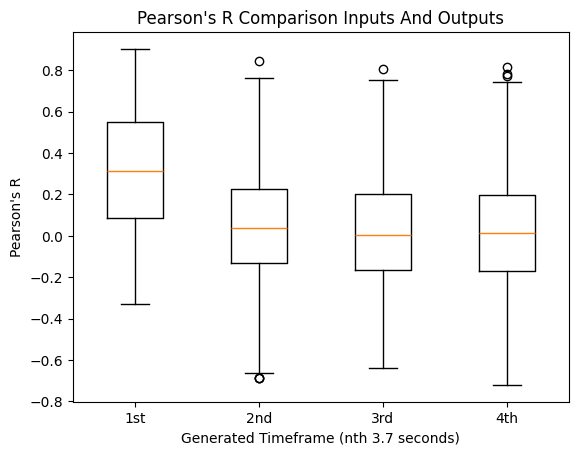

In [4]:
import matplotlib.pylab as plt

ax = plt.subplot()

r_list = []
for win in range(0, 4):
    rs = r_df.filter(
        pl.col("win") == win,
    ).drop(
        pl.col("name"),
        pl.col("music"),
    )["r"].to_numpy()
    r_list.append(rs)
ax.boxplot(r_list)
ax.set_xticklabels(["1st", "2nd", "3rd", "4th"])
ax.set_xlabel("Generated Timeframe (nth 3.7 seconds)")
ax.set_ylabel("Pearson's R")
ax.set_title("Pearson's R Comparison Inputs And Outputs")
plt.show()


## Pearson's R Comparison For Different Music Genres

We generated the output on 10 different genres of music as labeled by the AIST dance database dataset.
This comparison is to see the difference that different music genres has on the relevance of the input to the output per time ordinal.

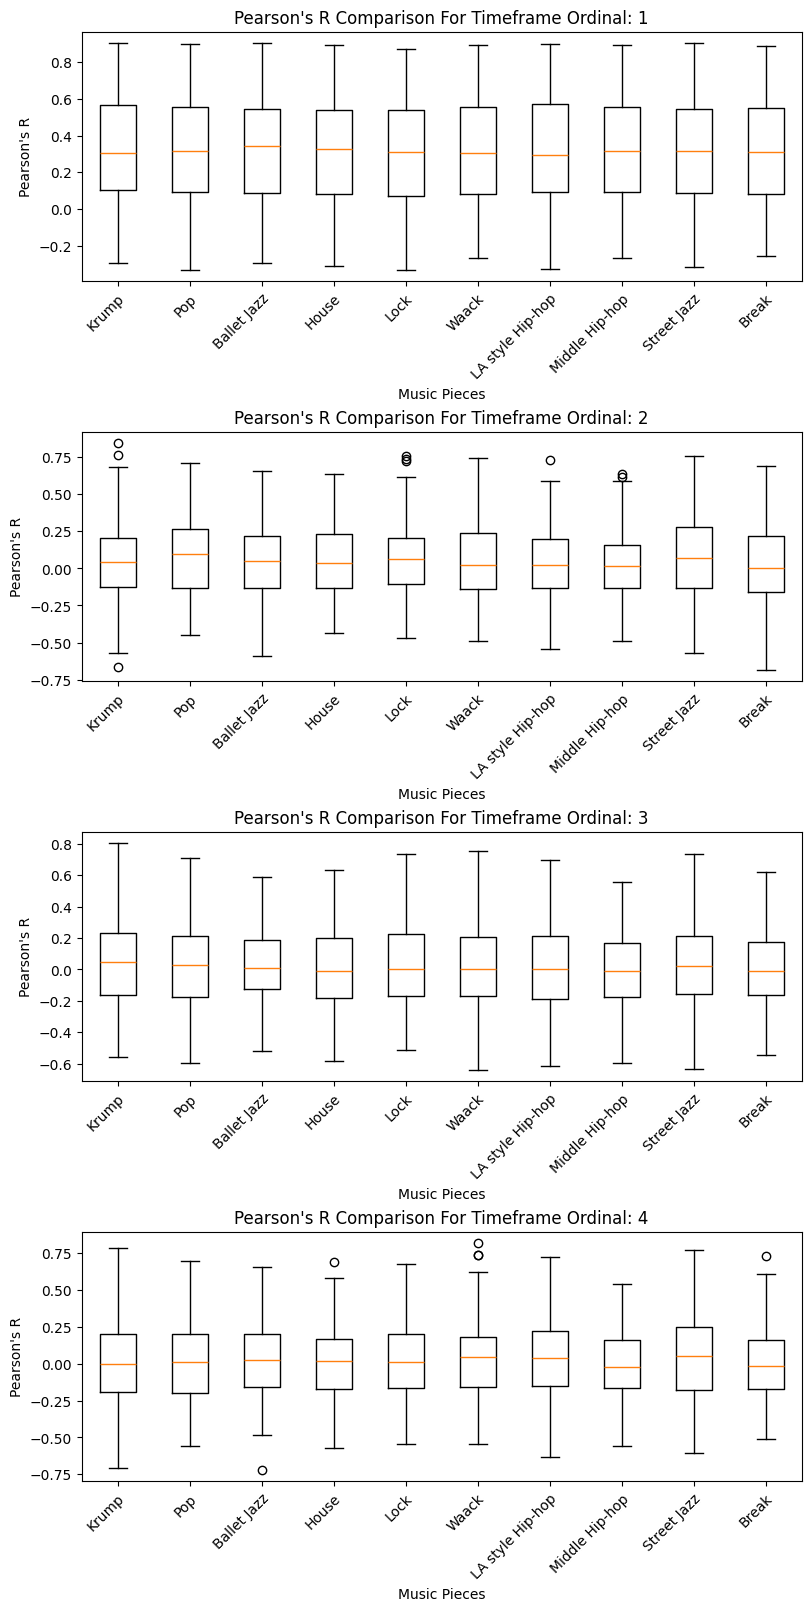

In [5]:
import matplotlib.pylab as plt

music_dict = {
    "mBR0": "Break",
    "mPO0": "Pop",
    "mLO0": "Lock",
    "mMH0": "Middle Hip-hop",
    "mLH0": "LA style Hip-hop",
    "mHO0": "House",
    "mWA0": "Waack",
    "mKR0": "Krump",
    "mJS0": "Street Jazz",
    "mJB0": "Ballet Jazz",
}

fig, axs = plt.subplots(4, 1, figsize=(8, 16), layout="constrained")
for win in range(0, 4):
    r_list = []
    music_list = []
    for i, music in enumerate(musics):
        rs = r_df.filter(
            pl.col("win") == win,
            pl.col("music") == music,
        ).drop(
            pl.col("name"),
            pl.col("music"),
        )["r"].to_numpy()
        r_list.append(rs)
        music_list.append(music_dict[music])
        
    axs[win].boxplot(r_list)
    axs[win].set_xticklabels(music_list, rotation=45, ha="right", rotation_mode="anchor")
    axs[win].set_xlabel("Music Pieces")
    axs[win].set_ylabel("Pearson's R")
    axs[win].set_title(f"Pearson's R Comparison For Timeframe Ordinal: {win + 1}")
plt.show()

## Pearson's R Comparison for Different Clusters

This comparison compares how input motion from different clusters has different relevance for their output

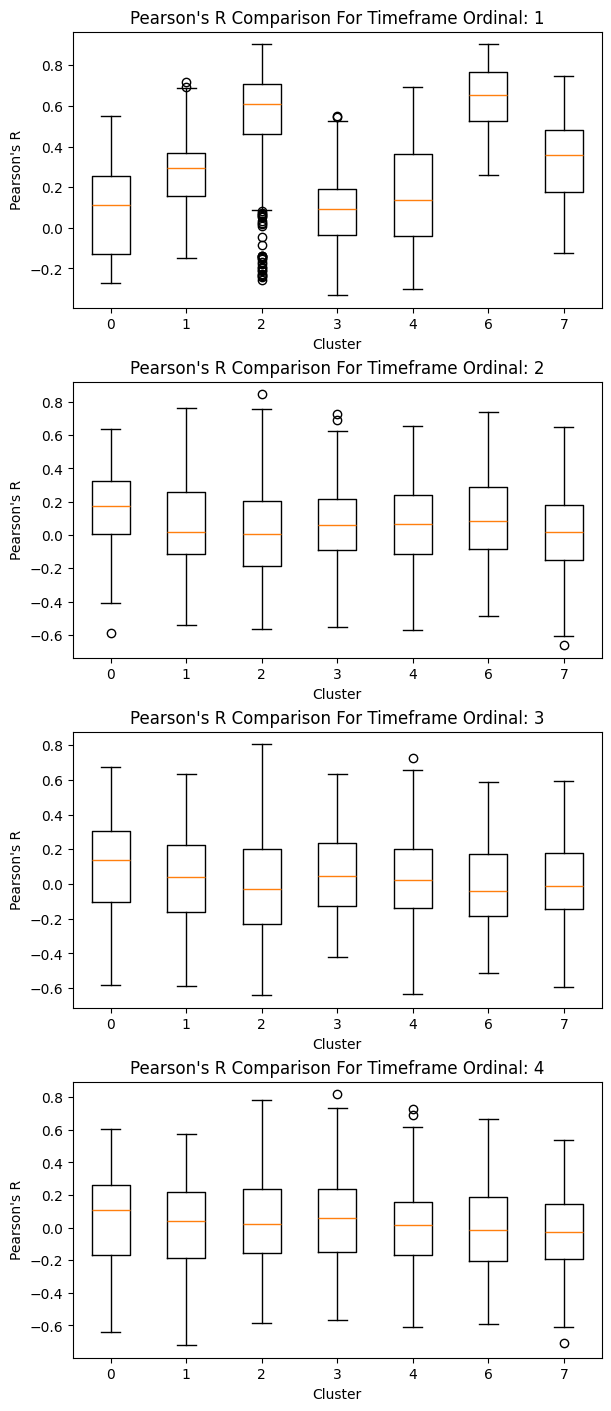

In [6]:

import matplotlib.pylab as plt

fig, axs = plt.subplots(4, 1, figsize=(6, 14), layout="constrained")
cluster_df = pl.read_csv("k-means-8n.csv").filter(
    pl.col("cluster") != 5
)
joined_df = r_df.join(
    cluster_df,
    on=pl.col("name"),
    how="inner"
)
clusters = cluster_df["cluster"].unique().to_list()

for win in range(0, 4):
    r_list = []
    for cluster in clusters:
        rs = joined_df.filter(
            pl.col("win") == win,
            pl.col("cluster") == cluster,
        )["r"].to_numpy()
        r_list.append(rs)
        
    axs[win].boxplot(r_list)
    axs[win].set_xticklabels(clusters)
    axs[win].set_xlabel("Cluster")
    axs[win].set_ylabel("Pearson's R")
    axs[win].set_title(f"Pearson's R Comparison For Timeframe Ordinal: {win + 1}")
plt.show()

## Person's R Comparison For Different Music and Different Clusters
The purpose of this comparison is to see what cluster paired with what music generates highly relevant output, which what cluster and what music combination results in less relevant outputs.

**Still need to figure out a better way to display this information**

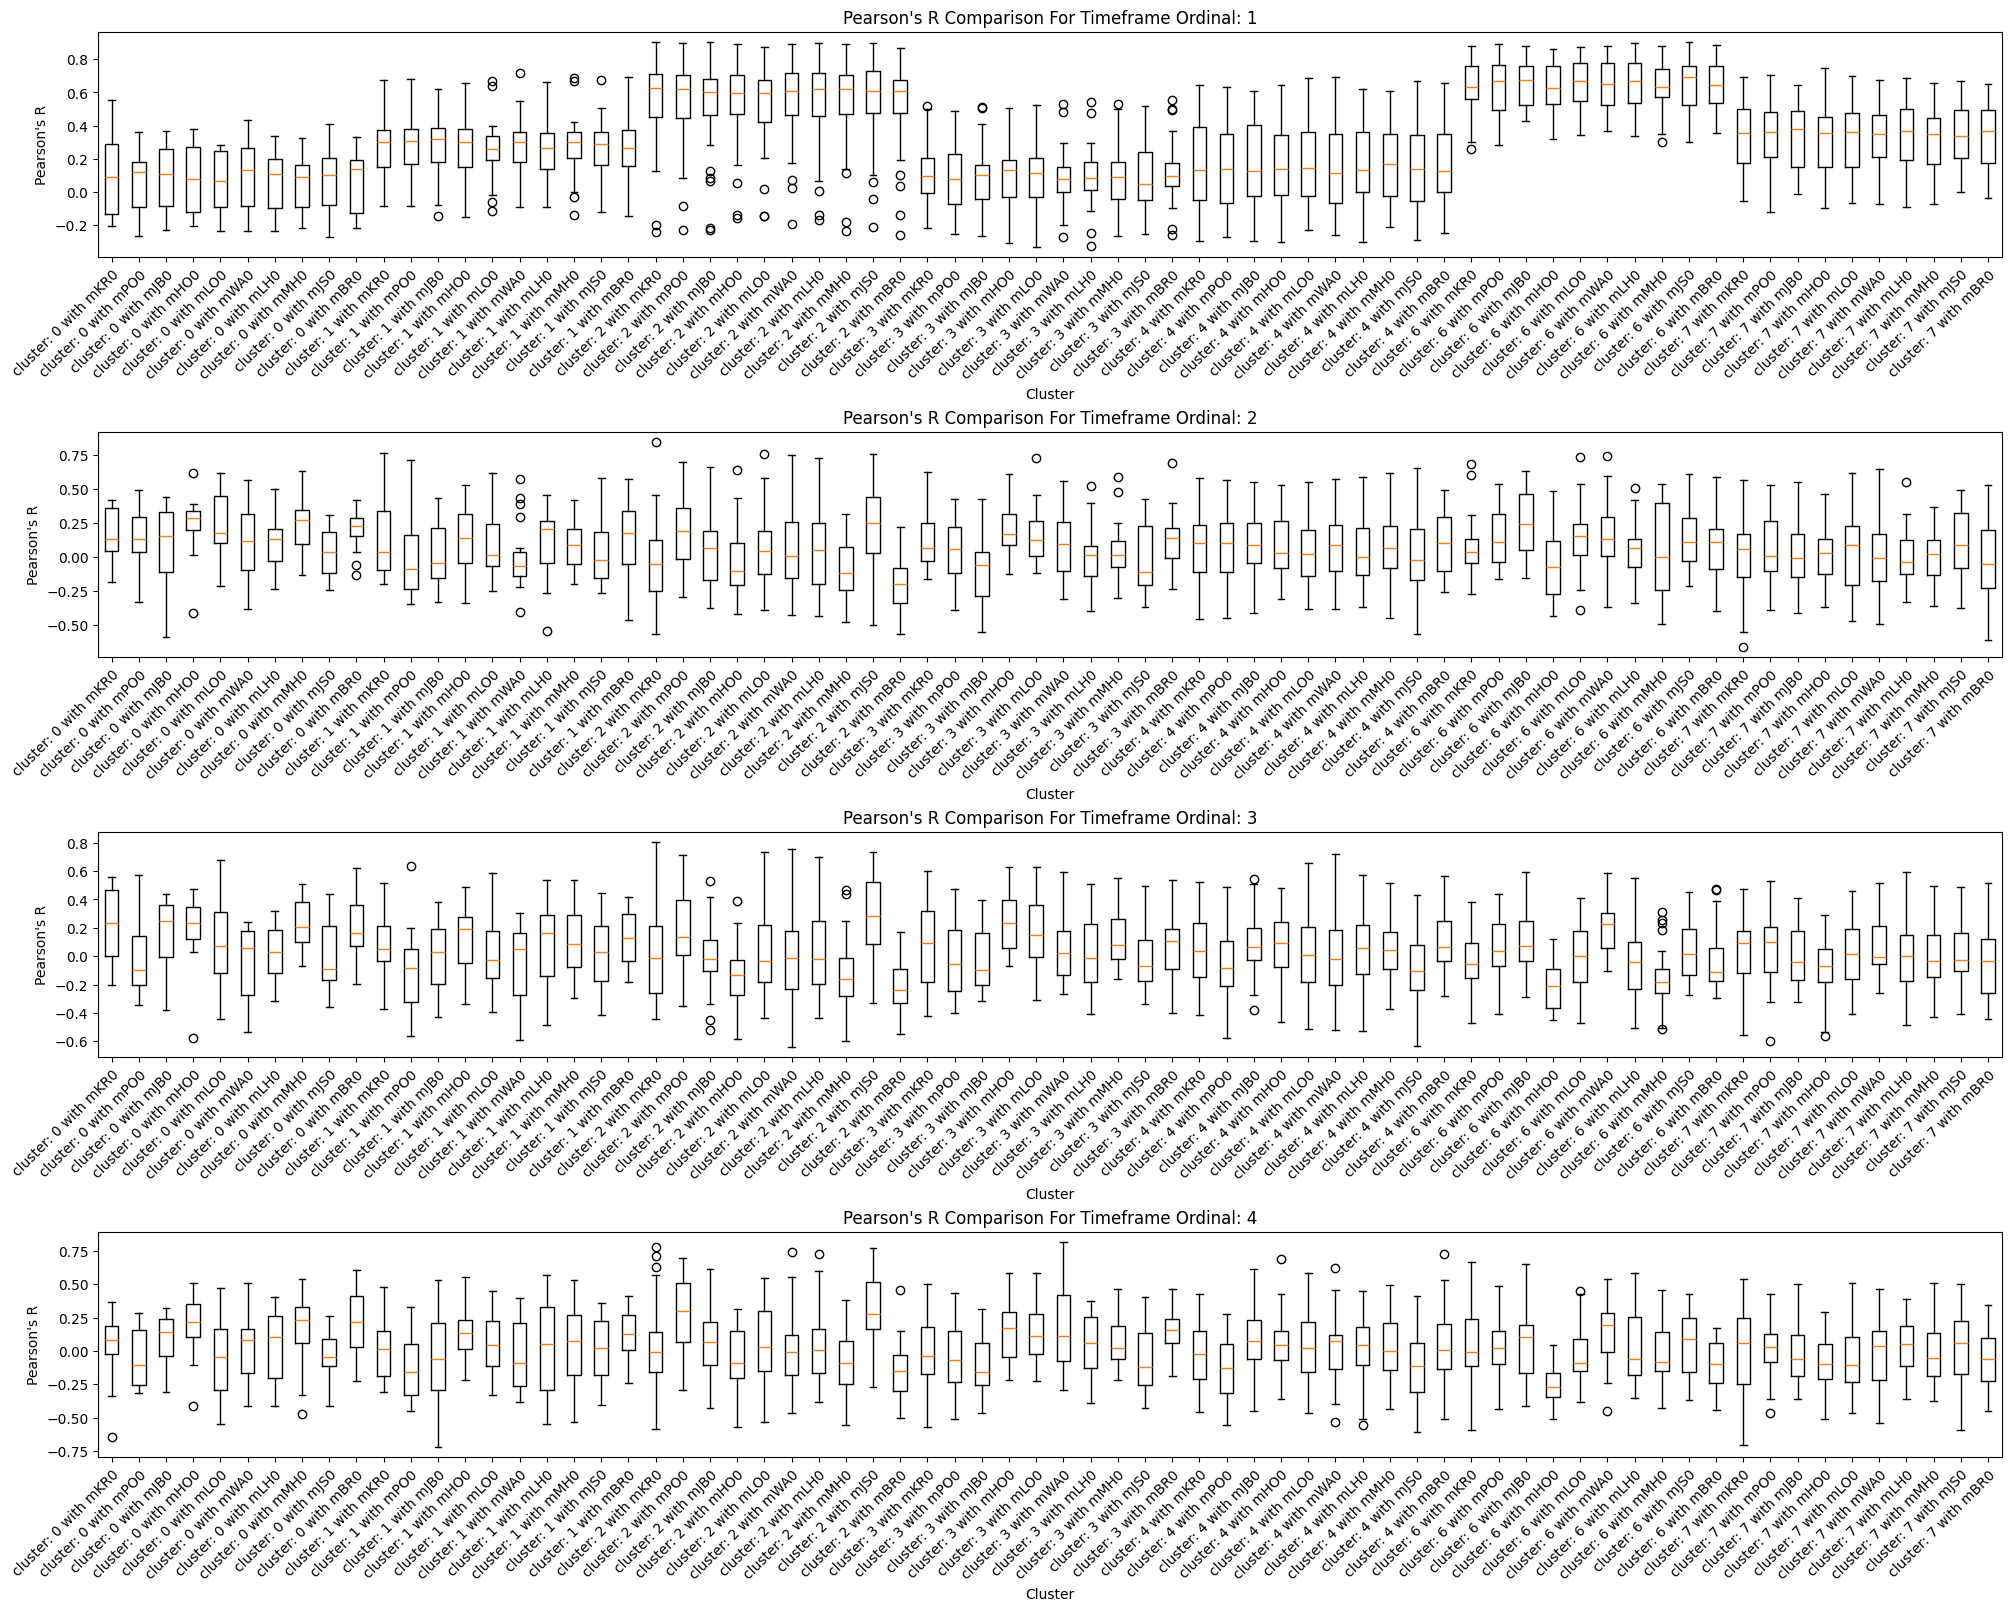

In [7]:
import matplotlib.pylab as plt

fig, axs = plt.subplots(4, 1, figsize=(20, 16), layout="constrained")
cluster_df = pl.read_csv("k-means-8n.csv").filter(
    pl.col("cluster") != 5
)
joined_df = r_df.join(
    cluster_df,
    on=pl.col("name"),
    how="inner"
)
clusters = cluster_df["cluster"].unique().to_list()

for win in range(0, 4):
    r_list = []
    label_list = []
    for cluster in clusters:
        for music in musics:
            rs = joined_df.filter(
                pl.col("win") == win,
                pl.col("music") == music,
                pl.col("cluster") == cluster,
            )["r"].to_numpy()
            r_list.append(rs)
            label_list.append(f"cluster: {cluster} with {music}")
        
    axs[win].boxplot(r_list)
    axs[win].set_xticklabels(label_list, rotation=45, ha="right", rotation_mode="anchor")
    axs[win].set_xlabel("Cluster")
    axs[win].set_ylabel("Pearson's R")
    axs[win].set_title(f"Pearson's R Comparison For Timeframe Ordinal: {win + 1}")
plt.show()


## Per Genre Of Music, Find Which Cluster Grants Highest Mean R


Text(0.5, 1.0, "Pearson's R Comparison Most Impacted Cluster Per Music")

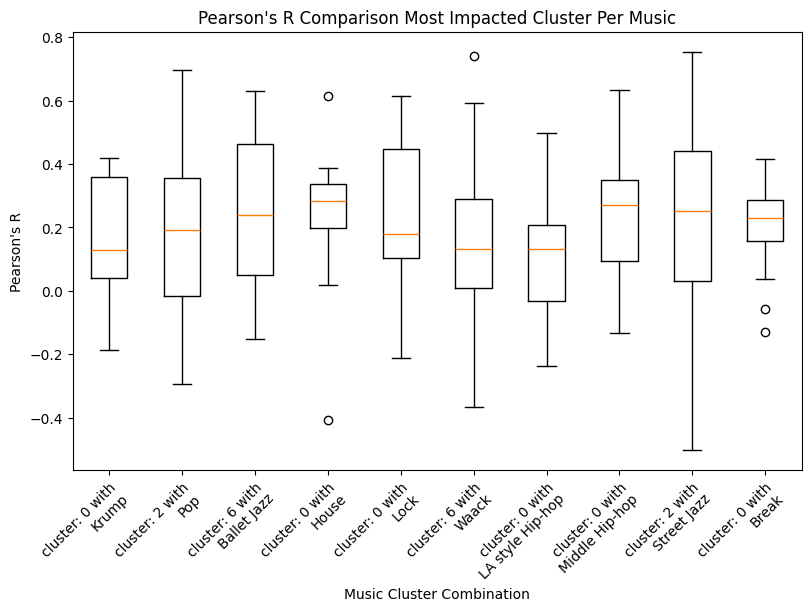

In [8]:

# Do this for ordinal 1 first
win = 1
r_dict = {}
order_df = pl.DataFrame()
for cluster in clusters:
    for music in musics:
        rs = joined_df.filter(
            pl.col("win") == win,
            pl.col("music") == music,
            pl.col("cluster") == cluster,
        )["r"].to_numpy()
        music_name = music_dict[music]
        label = f"cluster: {cluster} with\n{music_name}"
        r_dict[label] = rs
        order_dict = {
            "mean": rs.mean(),
            "music": music,
            "label": label,
        }
        cur_df = pl.from_dict(order_dict)
        order_df = order_df.vstack(cur_df)

fig, ax = plt.subplots(1, 1, figsize=(8, 6), layout="constrained")
rs = []
labels = []
for music in musics:
    cur_df = order_df.filter(
        pl.col("music") == music
    )
    cur_df = cur_df.sort(by=pl.col("mean"), descending=True)
    row = cur_df.row(0, named=True)

    rs.append(r_dict[row["label"]])
    labels.append(row["label"])

ax.boxplot(rs)
ax.set_xticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")
ax.set_xlabel("Music Cluster Combination")
ax.set_ylabel("Pearson's R")
ax.set_title("Pearson's R Comparison Most Impacted Cluster Per Music")


## Per Cluster, Find Which Genre Of Music Grants Highest Mean R

Text(0.5, 1.0, "Pearson's R Comparison For Best Music For Each Cluster")

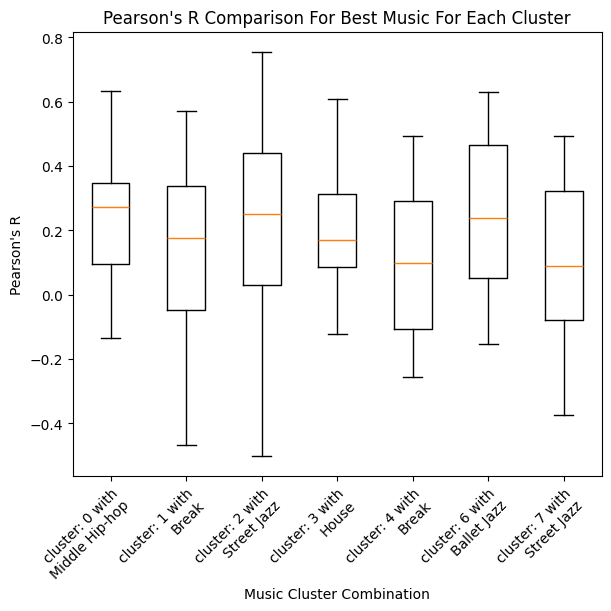

In [9]:
import numpy as np

# Do this for ordinal 1 first
win = 1
r_dict = {}
order_df = pl.DataFrame()
for cluster in clusters:
    for music in musics:
        rs = joined_df.filter(
            pl.col("win") == win,
            pl.col("music") == music,
            pl.col("cluster") == cluster,
        )["r"].to_numpy()
        music_name = music_dict[music]
        label = f"cluster: {cluster} with\n{music_name}"
        r_dict[label] = rs
        order_dict = {
            "sort_key": rs.mean(),
            "cluster": cluster,
            "label": label,
        }
        cur_df = pl.from_dict(order_dict)
        order_df = order_df.vstack(cur_df)

fig, ax = plt.subplots(1, 1, figsize=(6, 6), layout="constrained")
rs = []
labels = []
for cluster in clusters:
    cur_df = order_df.filter(
        pl.col("cluster") == cluster
    )
    cur_df = cur_df.sort(by=pl.col("sort_key"), descending=True)
    row = cur_df.row(0, named=True)

    rs.append(r_dict[row["label"]])
    labels.append(row["label"])

ax.boxplot(rs)
ax.set_xticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")
ax.set_xlabel("Music Cluster Combination")
ax.set_ylabel("Pearson's R")
ax.set_title("Pearson's R Comparison For Best Music For Each Cluster")

In [10]:

# get high correlation groups
for music in musics:
    best_df = joined_df.filter(
        pl.col("win") == 1,
        pl.col("music") == music
    ).top_k(
        5, by="r"
    )
    best_df.select(
        pl.col("name"),
        pl.col("music"),
        pl.col("cluster"),
    ).write_csv(
        f"best_dances_{music}.csv"
    )

# get low correlation groups
for music in musics:
    best_df = joined_df.filter(
        pl.col("win") == 1,
        pl.col("music") == music
    ).bottom_k(
        5, by="r"
    )
    best_df.select(
        pl.col("name"),
        pl.col("music"),
        pl.col("cluster"),
    ).write_csv(
        f"worst_dances_{music}.csv"
    )


## Method 2: Using Euclidean Distance To Measure Similarity Of Motion

In [11]:
# Analysis 3 - get r value of input to output
from scipy.stats import pearsonr
from tqdm import tqdm
import math

def euclid_dist(pt1, pt2):
    dist = 0
    for f1, f2 in zip(pt1, pt2):
        dist += (f1 - f2) ** 2
    return math.sqrt(dist)


input_df = pl.read_csv("features_complete.csv") 
output_df = df.clone()
output_df = output_df.drop(
    pl.selectors.ends_with("_min"),
    pl.selectors.starts_with("f12_"),
    pl.selectors.starts_with("f16_"),
)
# scale output
scaling_df = output_df.drop(
    pl.col("name"),
    pl.col("num"),
    pl.col("win_total"),
    pl.col("win_split"),
    pl.col("music"),
)
concat_df = output_df.select(
    pl.col("name"),
    pl.col("num"),
    pl.col("win_total"),
    pl.col("win_split"),
    pl.col("music"),
)
scaling_df = pl.DataFrame(scaler.fit_transform(scaling_df))
output_df = scaling_df.hstack(concat_df)
print(output_df)

# scaling input
scaling_df = input_df.drop(
    pl.col("name")
)
concat_df = input_df.select(
    pl.col("name")
)
scaling_df = pl.DataFrame(scaler.fit_transform(scaling_df))
input_df = scaling_df.hstack(concat_df)
print(input_df)

names = input_df.filter(
    pl.col("name") != "dance_data_23_corrected"
)["name"].unique().to_list()
musics = output_df["music"].unique().to_list()


euc_df = pl.DataFrame()
for name in tqdm(names):
    for music in musics:
        inputs = input_df.filter(pl.col("name") == name).drop("name").to_numpy()
        outputs = output_df.filter(
            pl.col("name") == name,
            pl.col("num") == "0",
            pl.col("win_total") == "3",
            pl.col("music") == music,
        ).drop("name", "num", "win_total", "music")

        for win in range(0, 4):
            output = outputs.filter(pl.col("win_split") == str(win)).drop("win_split").to_numpy()
            euc_dist = euclid_dist(inputs[0, :], output[0, :])
            euc_dict = {"name": name, "music": music, "win": win, "euc": euc_dist}
            euc_df = euc_df.vstack(pl.from_dict(euc_dict))
    
euc_df.write_parquet("r_val_df.parquet")

shape: (191_700, 56)
┌───────────┬───────────┬───────────┬───────────┬───┬─────┬───────────┬───────────┬───────┐
│ column_0  ┆ column_1  ┆ column_2  ┆ column_3  ┆ … ┆ num ┆ win_total ┆ win_split ┆ music │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ --- ┆ ---       ┆ ---       ┆ ---   │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ str ┆ str       ┆ str       ┆ str   │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═════╪═══════════╪═══════════╪═══════╡
│ -0.675401 ┆ 1.25513   ┆ -1.512881 ┆ 0.507833  ┆ … ┆ 9   ┆ 1         ┆ 0         ┆ mJS0  │
│ 0.228852  ┆ -0.977964 ┆ 0.753469  ┆ 0.493649  ┆ … ┆ 9   ┆ 3         ┆ 3         ┆ mJS0  │
│ -4.709402 ┆ 1.148645  ┆ -3.15279  ┆ 0.670895  ┆ … ┆ 4   ┆ 2         ┆ 2         ┆ mMH0  │
│ 0.212938  ┆ -1.078354 ┆ 0.761838  ┆ -0.654888 ┆ … ┆ 7   ┆ 3         ┆ 0         ┆ mJS0  │
│ 0.244293  ┆ -0.290751 ┆ 0.359497  ┆ -0.360815 ┆ … ┆ 3   ┆ 3         ┆ 3         ┆ mLO0  │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …   ┆

 62%|██████▏   | 133/213 [00:12<00:07, 10.27it/s]


KeyboardInterrupt: 

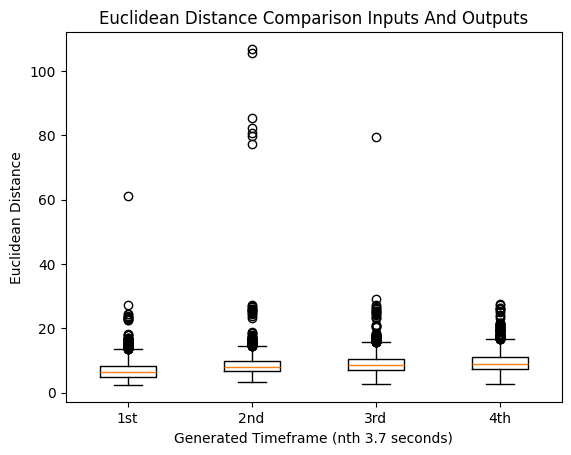

In [23]:
import matplotlib.pylab as plt

ax = plt.subplot()

euc_list = []
for win in range(0, 4):
    euc_dists = euc_df.filter(
        pl.col("win") == win,
    ).drop(
        pl.col("name"),
        pl.col("music"),
    )["euc"].to_numpy()
    euc_list.append(euc_dists)
ax.boxplot(euc_list)
ax.set_xticklabels(["1st", "2nd", "3rd", "4th"])
ax.set_xlabel("Generated Timeframe (nth 3.7 seconds)")
ax.set_ylabel("Euclidean Distance")
ax.set_title("Euclidean Distance Comparison Inputs And Outputs")
plt.show()

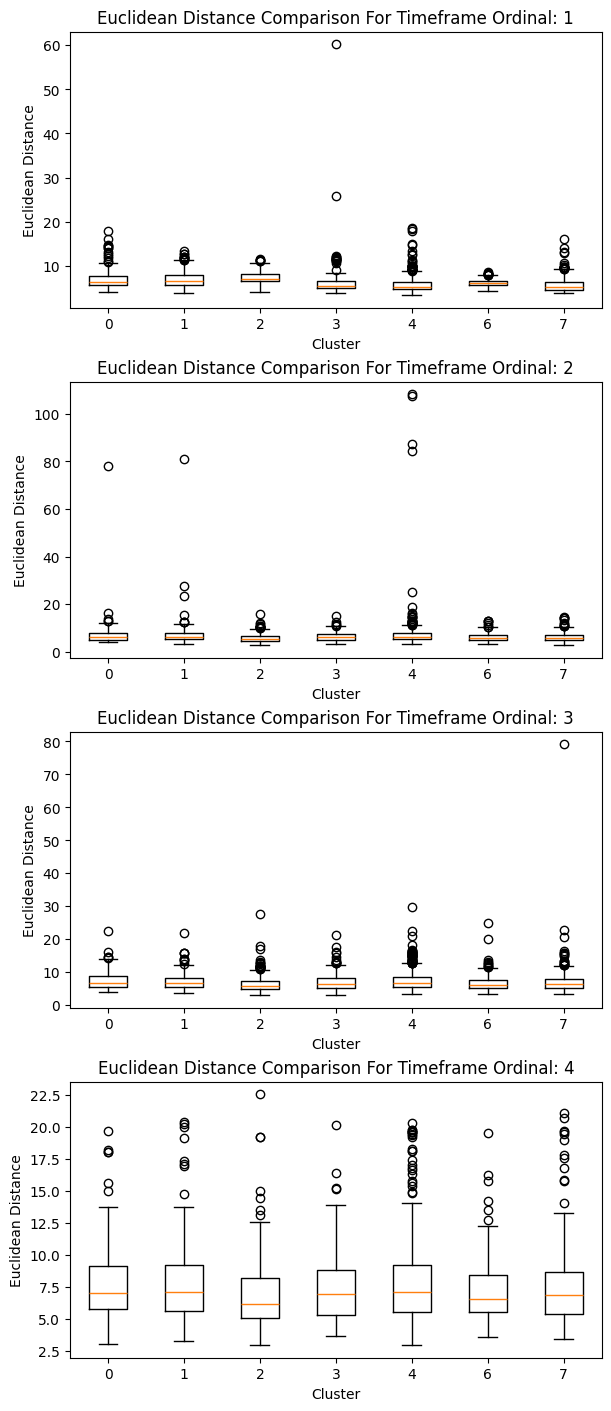

In [35]:
import matplotlib.pylab as plt

fig, axs = plt.subplots(4, 1, figsize=(6, 14), layout="constrained")
cluster_df = pl.read_csv("k-means-8n.csv").filter(
    pl.col("cluster") != 5
)
joined_df = euc_df.join(
    cluster_df,
    on=pl.col("name"),
    how="inner"
)
clusters = cluster_df["cluster"].unique().to_list()

for win in range(0, 4):
    euc_list = []
    for cluster in clusters:
        euc_dists = joined_df.filter(
            pl.col("win") == win,
            pl.col("cluster") == cluster,
        )["euc"].to_numpy()
        euc_list.append(euc_dists)
        
    axs[win].boxplot(euc_list)
    axs[win].set_xticklabels(clusters)
    axs[win].set_xlabel("Cluster")
    axs[win].set_ylabel("Euclidean Distance")
    axs[win].set_title(f"Euclidean Distance Comparison For Timeframe Ordinal: {win + 1}")